In [1]:
%matplotlib inline
import sys, os
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(root_dir)
sys.path.append(root_dir + "/trajectron")
print(f'sys.path: {sys.path}')
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization

sys.path: ['/home/t/thanh/anaconda3/envs/unlike/lib/python36.zip', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/lib-dynload', '', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages', '/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/IPython/extensions', '/home/t/thanh/.ipython', '/home/t/thanh/UnlikelihoodMotionForecasting', '/home/t/thanh/UnlikelihoodMotionForecasting/trajectron']


# Load nuScenes SDK and data

In [2]:
nuScenes_data_path = '/home/t/thanh/data/nuScenes/v1.0-mini'
nuScenes_devkit_path = '/home/t/thanh/nuscenes-devkit/python-sdk'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [3]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

with open('/home/t/thanh/data/nuScenes_preprocessed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

ph = 6
log_dir = './models'
scene = eval_scenes[25]
scene.name

# Define ROI in nuScenes Map
x_min = 773.0
x_max = 1100.0
y_min = 1231.0
y_max = 1510.0

layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

# Trajectron - int_ee_me


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the o

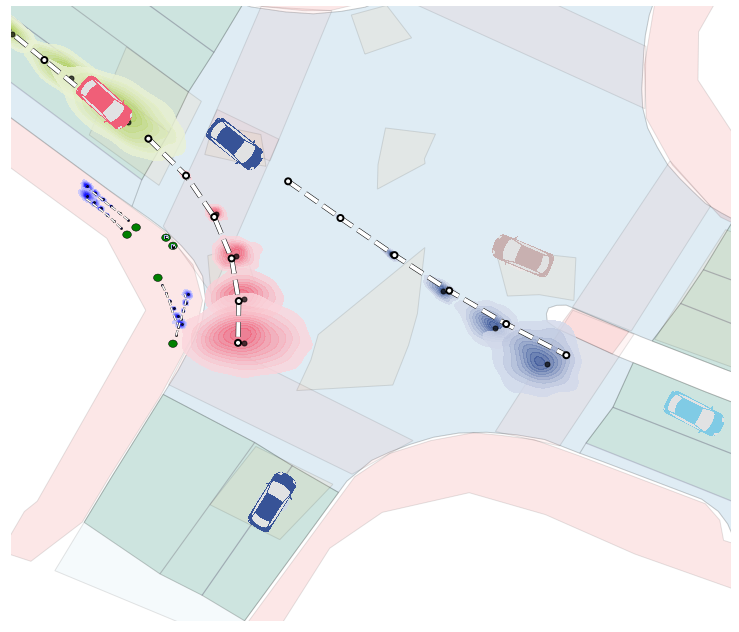

In [5]:
model_dir = os.path.join(log_dir, 'int_ee_me') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=12)

with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('/home/t/thanh/output/plots/qual_nuScenes_trajectron_int_ee_me.pdf', dpi=300, bbox_inches='tight')

# Trajectron - trajectron_pp


Loading from ./models/trajectron_pp/model_registrar-29.pt
Loaded!



/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the o

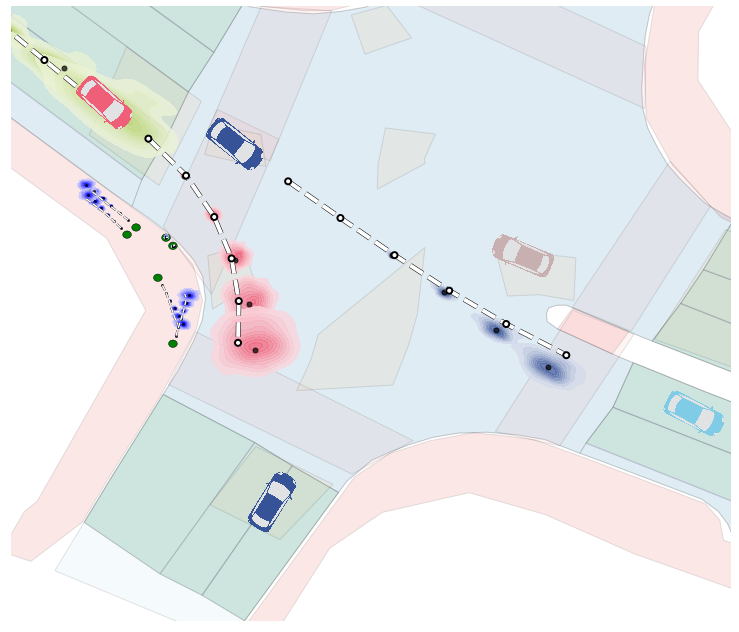

In [6]:
model_dir = os.path.join(log_dir, 'trajectron_pp') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=29)

with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('/home/t/thanh/output/plots/qual_nuScenes_trajectron_pp.pdf', dpi=300, bbox_inches='tight')

# Unlikelihood


Loading from ./models/unlikelihood/model_registrar-31.pt
Loaded!



/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/t/thanh/anaconda3/envs/unlike/lib/python3.6/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the o

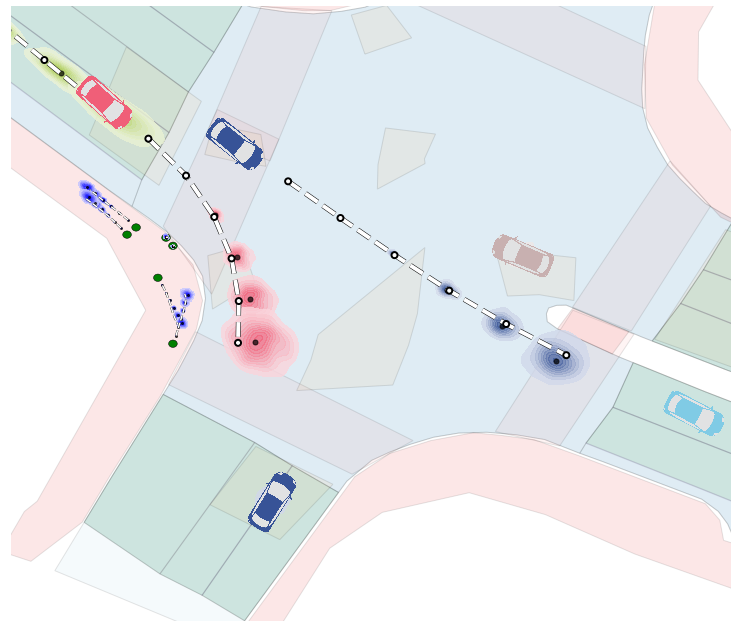

In [7]:
model_dir = os.path.join(log_dir, 'unlikelihood') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=31)

with torch.no_grad():
    timestep = np.array([2])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples=500)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      z_mode=True,
                                      gmm_mode=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1385, 1435))
    ax.set_xlim((850, 900))
    leg = ax.legend(loc='upper right', fontsize=20, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    ax.get_legend().remove()
    fig.show()
    fig.savefig('/home/t/thanh/output/plots/qual_nuScenes_unlikelihood.pdf', dpi=300, bbox_inches='tight')

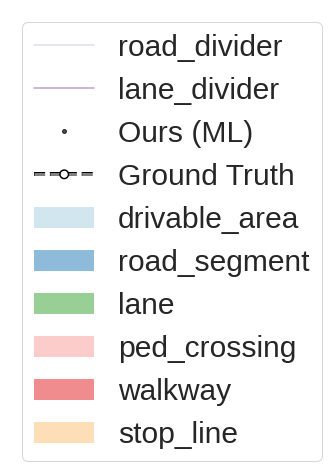

In [24]:
my_patch = (0, 0, 1, 1)
fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(1, 1), alpha=0.1, render_egoposes_range=False)
ax.plot([], [], 'ko',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (ML)')

ax.plot([],
        [],
        'w--o', label='Ground Truth',
        linewidth=3,
        path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
leg = ax.legend(loc='upper left', fontsize=30, frameon=True)
for lh in leg.legendHandles:
    lh.set_alpha(.5)
ax.axis('off')
ax.grid('off')
fig.savefig('/home/t/thanh/output/plots/qual_nuScenes_legend.pdf', dpi=300, bbox_inches='tight')